In [2]:
import sys, platform
print(sys.executable)            # 应该包含 .../envs/qb/bin/python
print(platform.python_version()) # 3.11.x

import numpy as np, pandas as pd, yfinance as yf, sklearn, statsmodels, numba
print("All good ✅")

/opt/miniconda3/bin/python
3.13.1
All good ✅



3 Failed downloads:
['MSFT', 'AAPL', 'SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


,mean,vol,skew,kurt
Ticker,,,,
AAPL,NaN,NaN,NaN,NaN
MSFT,NaN,NaN,NaN,NaN
SPY,NaN,NaN,NaN,NaN


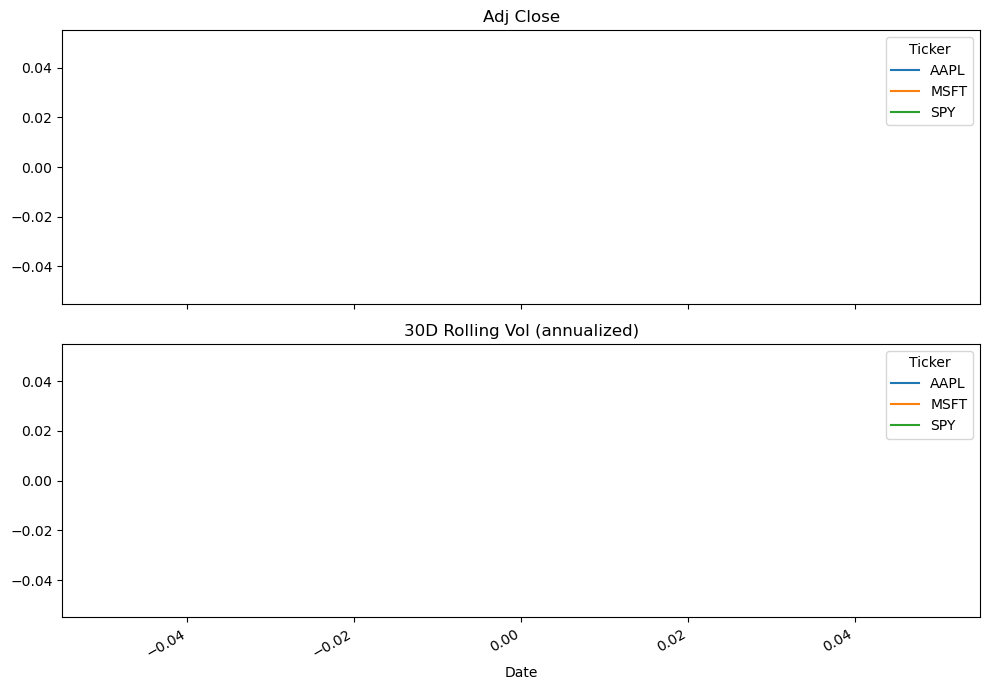

In [4]:
import pandas as pd, numpy as np, yfinance as yf
import matplotlib.pyplot as plt

tickers = ["AAPL","MSFT","SPY"]
df = yf.download(tickers, start="2019-01-01", auto_adjust=False, progress=False)

px = df["Adj Close"].dropna(how="all")
rets = np.log(px/px.shift(1)).dropna()

summary = pd.DataFrame({
    "mean": rets.mean()*252,
    "vol": rets.std()*np.sqrt(252),
    "skew": rets.skew(),
    "kurt": rets.kurt()
}).round(4)
display(summary)

fig, axes = plt.subplots(2,1, figsize=(10,7), sharex=True)
px.plot(ax=axes[0], title="Adj Close")
(rets.rolling(30).std()*np.sqrt(252)).plot(ax=axes[1], title="30D Rolling Vol (annualized)")
plt.tight_layout(); plt.show()

YF.download() has changed argument auto_adjust default to True



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


,mean,vol,skew,kurt
Ticker,,,,
AAPL,NaN,NaN,NaN,NaN
MSFT,NaN,NaN,NaN,NaN
SPY,NaN,NaN,NaN,NaN


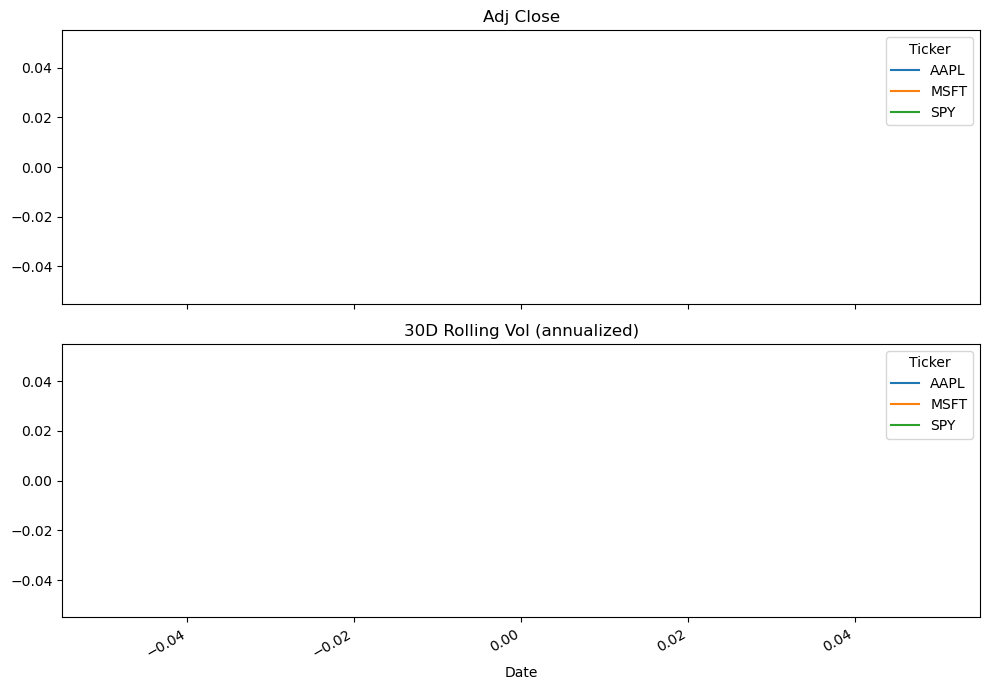

In [5]:
import time
import numpy as np, pandas as pd, yfinance as yf
import matplotlib.pyplot as plt

tickers = ["AAPL","MSFT","SPY"]
frames = []
for t in tickers:
    # 单只下载 + 轻微延时，避免触发限流；threads=False 更稳
    s = yf.download(t, start="2019-01-01", progress=False, threads=False)["Adj Close"]
    s.name = t
    frames.append(s)
    time.sleep(1.5)  # 1~2 秒即可

px = pd.concat(frames, axis=1).dropna(how="all")
rets = np.log(px/px.shift(1)).dropna()

summary = pd.DataFrame({
    "mean": rets.mean()*252,
    "vol": rets.std()*np.sqrt(252),
    "skew": rets.skew(),
    "kurt": rets.kurt()
}).round(4)
display(summary)

fig, axes = plt.subplots(2,1, figsize=(10,7), sharex=True)
px.plot(ax=axes[0], title="Adj Close")
(rets.rolling(30).std()*np.sqrt(252)).plot(ax=axes[1], title="30D Rolling Vol (annualized)")
plt.tight_layout(); plt.show()

In [6]:
from pathlib import Path
import time, random
import numpy as np, pandas as pd, yfinance as yf

cache = Path("data/px_yahoo.pkl")
tickers = ["AAPL","MSFT","SPY"]

def fetch_one(t, start="2019-01-01", tries=6):
    for i in range(tries):
        try:
            s = yf.download(t, start=start, progress=False, threads=False)["Adj Close"]
            s.name = t
            if s.empty: raise RuntimeError("empty")
            return s
        except Exception as e:
            if any(k in str(e) for k in ["Rate limited", "Too Many Requests", "429", "503"]):
                wait = min(60, 2**i + random.random()*3)
                print(f"[{t}] rate limited, retry in {wait:.1f}s...")
                time.sleep(wait)
                continue
            raise

if cache.exists():
    px = pd.read_pickle(cache)
else:
    frames = [fetch_one(t) for t in tickers]
    px = pd.concat(frames, axis=1).sort_index()
    cache.parent.mkdir(parents=True, exist_ok=True)
    px.to_pickle(cache)

rets = np.log(px/px.shift(1)).dropna()
display(px.tail(), rets.tail())


1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


RuntimeError: empty

In [7]:
from pathlib import Path
import time, random
import numpy as np, pandas as pd, yfinance as yf
import matplotlib.pyplot as plt

cache = Path("data/px_yahoo.pkl")
tickers = ["AAPL","MSFT","SPY"]

def fetch_one(t, start="2019-01-01", tries=8):
    last_err = None
    for i in range(tries):
        try:
            s = yf.download(t, start=start, progress=False, threads=False)["Adj Close"]
            if s is None or s.empty:
                raise RuntimeError("empty")  # 视为空数据=需要重试
            s.name = t
            return s
        except Exception as e:
            last_err = e
            msg = str(e)
            # 对 429/503/empty 等情况都重试
            wait = min(90, 2**i + random.random()*2)
            print(f"[{t}] retry {i+1}/{tries} in {wait:.1f}s | {msg}")
            time.sleep(wait)
            continue
    raise RuntimeError(f"{t} failed after {tries} tries: {last_err}")

if cache.exists():
    px = pd.read_pickle(cache)
else:
    frames = [fetch_one(t) for t in tickers]
    px = pd.concat(frames, axis=1).sort_index()
    cache.parent.mkdir(parents=True, exist_ok=True)
    px.to_pickle(cache)

rets = np.log(px/px.shift(1)).dropna()

summary = pd.DataFrame({
    "mean": rets.mean()*252,
    "vol": rets.std()*np.sqrt(252),
    "skew": rets.skew(),
    "kurt": rets.kurt()
}).round(4)
display(summary)

fig, axes = plt.subplots(2,1, figsize=(10,7), sharex=True)
px.plot(ax=axes[0], title="Adj Close")
(rets.rolling(30).std()*np.sqrt(252)).plot(ax=axes[1], title="30D Rolling Vol (annualized)")
plt.tight_layout(); plt.show()


1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 1/8 in 2.8s | empty



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 2/8 in 3.6s | empty



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 3/8 in 5.0s | empty



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 4/8 in 8.4s | empty



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 5/8 in 18.0s | empty



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 6/8 in 32.4s | empty



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 7/8 in 64.7s | empty



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


[AAPL] retry 8/8 in 90.0s | empty


KeyboardInterrupt: 

In [ ]:
!pip install -q pandas-datareader

In [8]:
!pip install -q pandas-datareader

,mean,vol,skew,kurt
AAPL,0.2744,0.3158,-0.0879,6.4958
MSFT,0.2583,0.2888,-0.1896,7.9336
SPY,0.1568,0.2023,-0.5784,13.7828


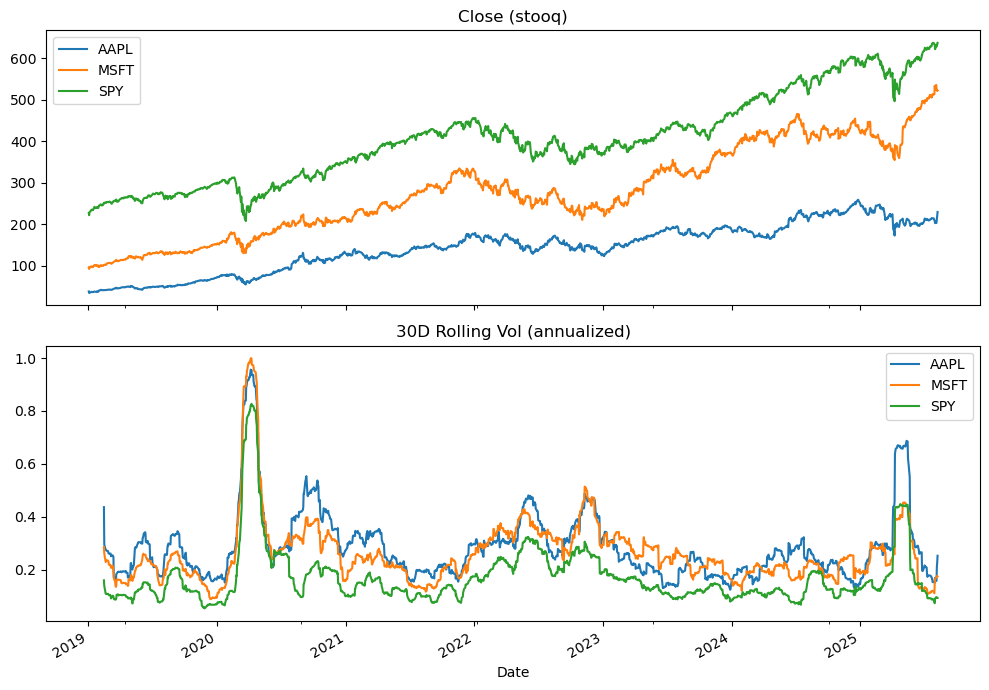

In [9]:
import numpy as np, pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

tickers = ["AAPL","MSFT","SPY"]

# 从 stooq 拉数据（稳定、免费）
dfs = []
for t in tickers:
    s = pdr.DataReader(t, "stooq", start="2019-01-01")["Close"].sort_index()
    s.name = t
    dfs.append(s)

px = pd.concat(dfs, axis=1)              # 收盘价
rets = np.log(px/px.shift(1)).dropna()   # 对数收益

# 简单统计表
summary = pd.DataFrame({
    "mean": rets.mean()*252,
    "vol": rets.std()*np.sqrt(252),
    "skew": rets.skew(),
    "kurt": rets.kurt()
}).round(4)
display(summary)

# 画图
fig, axes = plt.subplots(2,1, figsize=(10,7), sharex=True)
px.plot(ax=axes[0], title="Close (stooq)")
(rets.rolling(30).std()*np.sqrt(252)).plot(ax=axes[1], title="30D Rolling Vol (annualized)")
plt.tight_layout(); plt.show()

In [10]:
from pathlib import Path
Path("data").mkdir(exist_ok=True)
px.to_csv("data/prices_stooq.csv")
rets.to_csv("data/returns_stooq.csv")

In [11]:
conda env export --name qb --no-builds > env.yml


Note: you may need to restart the kernel to use updated packages.
